## Splink data linking and deduplication demo 

In this demo we link and simultaneously two datasets which themselves contain duplicates.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark()

## Step 2:  Read in data

The `l` and `r` stand for 'left' and 'right.  It doesn't matter which of the two datasets you choose as the left, performance and results will be the same.


⚠️ Note that `splink` makes the following assumptions about your data:

-  There is a field containing a unique record identifier in each dataset
-  The two datasets being linked have common column names - e.g. date of birth is represented in both datasets in a field of the same name.   In many cases, this means that the user needs to rename columns prior to using `splink`


In [5]:

from pyspark.sql import functions as f
df_l = spark.read.parquet("data/fake_df_l_link_dedupe_test.parquet")
df_r = spark.read.parquet("data/fake_df_r_link_dedupe_test.parquet")
df_l.show(5)
df_r.show(5)

+---------+----------+-------+----------+------------+--------------------+-----+
|unique_id|first_name|surname|       dob|        city|               email|group|
+---------+----------+-------+----------+------------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|      London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|      London| hannah88@powers.com|    0|
|        2|      oNah| Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|        3|     Noah | Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|        4|    Molly |   Bell|2002-01-05|Peterborough|                null|    2|
+---------+----------+-------+----------+------------+--------------------+-----+
only showing top 5 rows

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        

## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [8]:
settings = {
    "link_type": "link_and_dedupe",
    "blocking_rules": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
        "l.dob = r.dob"
    ],
    "comparison_columns": [
       {
        "custom_name": "name_inversion",
        "custom_columns_used": ["first_name", "surname", "dob"],
        "case_expression": "CASE WHEN first_name_l = first_name_r AND surname_l = surname_r THEN 2 WHEN first_name_l = surname_r AND surname_l = first_name_r THEN 1 ELSE 0 END",
        "num_levels": 3
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"]
}

In words, this setting dictionary says:
- We are performing a link and deduplication task (the other options are `link_only`, or `dedupe_only`)
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [9]:
from splink import Splink

linker = Splink(settings, spark, df_l=df_l, df_r=df_r)
df_e = linker.get_scored_comparisons()


INFO:splink.iterate:Iteration 0 complete
INFO:splink.params:The maximum change in parameters was 0.46443518400192263 for key π_gamma_name_inversion_prob_dist_match_level_0_probability
INFO:splink.iterate:Iteration 1 complete
INFO:splink.params:The maximum change in parameters was 0.05639684200286865 for key π_gamma_city_prob_dist_match_level_1_probability
INFO:splink.iterate:Iteration 2 complete
INFO:splink.params:The maximum change in parameters was 0.026586294174194336 for key π_gamma_city_prob_dist_match_level_1_probability
INFO:splink.iterate:Iteration 3 complete
INFO:splink.params:The maximum change in parameters was 0.01431041955947876 for key π_gamma_dob_prob_dist_non_match_level_0_probability
INFO:splink.iterate:Iteration 4 complete
INFO:splink.params:The maximum change in parameters was 0.011147737503051758 for key π_gamma_email_prob_dist_match_level_1_probability


## Step 5: Inspect results 

Each row in the results table represents a comparison of two input records.

Note that since this is a link and dedupe task, there will be record comparisons of three types:
-  Comparison between two records both originating from `df_l`.  
-  Comparison between two records both originating from `df_r`.  
-  Comparison between one record from `df_l` and one record from `df_r`

Information about the source table is included in the `_source_table_l` and `_source_table_r` fields.

In [10]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability","unique_id_l", "_source_table_l","unique_id_r","_source_table_r","group_l", "group_r", "first_name_l","first_name_r","surname_l","surname_r","dob_l","dob_r","city_l","city_r","email_l","email_r"]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,match_probability,unique_id_l,_source_table_l,unique_id_r,_source_table_r,group_l,group_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r
1,0.962228,0,left,0,right,0,0,Julia,Julia,None,Taylor,2015-10-29,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
0,0.998977,0,left,1,right,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
2,0.962228,0,left,1,left,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-07-31,London,London,hannah88@powers.com,hannah88@powers.com
1213,0.994881,0,right,1,right,0,0,Julia,Julia,Taylor,Taylor,2016-01-27,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
3585,0.025179,0,right,97,right,0,26,Julia,Harry,Taylor,Taylor,2016-01-27,2017-09-01,London,London,hannah88@powers.com,coltonray@lee.com
3584,0.025179,0,right,245,right,0,62,Julia,Nancy,Taylor,Taylor,2016-01-27,1989-07-25,London,London,hannah88@powers.com,wagnershane@landry.com
3583,0.025179,0,right,246,right,0,62,Julia,Nancy,Taylor,Taylor,2016-01-27,1989-08-19,London,London,hannah88@powers.com,wagnershane@landry.com
3582,0.025179,0,right,248,right,0,62,Julia,Nacy,Taylor,Taylor,2016-01-27,1989-07-25,London,London,hannah88@powers.com,wagnershane@landry.com
3581,0.001306,0,right,313,right,0,79,Julia,Isaac,Taylor,Taylor,2016-01-27,2008-07-01,London,Swindon,hannah88@powers.com,xday@higgins-lewis.com
3580,0.001306,0,right,314,right,0,79,Julia,None,Taylor,Taylor,2016-01-27,2008-08-22,London,Swindon,hannah88@powers.com,xd-y@higginsalwis.com


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

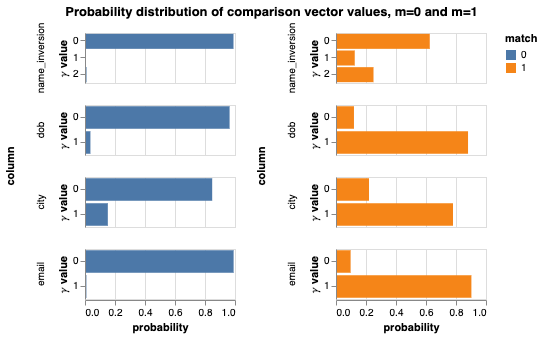

In [11]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

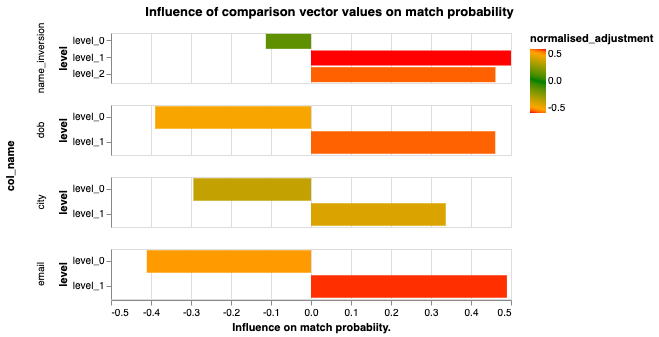

In [12]:
params.adjustment_factor_chart()

In [14]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
params.all_charts_write_html_file("splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.416987806558609

Comparison of name_inversion.  Values are:
name_inversion_l: Jones, Maya , 2010-06-21
name_inversion_r: Jones, Leo , 1983-08-31
Comparison has 3 levels
𝛾 for this comparison = gamma_name_inversion = 0
Amongst matches, P(𝛾 = 0.562960147857666):
Amongst non matches, P(𝛾 = 0.9908139705657959):
Adjustment factor = p1/(p1 + p2) = 0.36231788210558813
New probability of match (updated belief): 0.2889541112157693

Comparison of dob.  Values are:
dob_l: 2010-06-21
dob_r: 1983-08-31
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 0
Amongst matches, P(𝛾 = 0.13539652526378632):
Amongst non matches, P(𝛾 = 0.9843769073486328):
Adjustment factor = p1/(p1 + p2) = 0.120914214715657
New probability of match (updated belief): 0.052936641498986206

Comparison of city.  Values are:
city_l: Sunderland
city_r: Manchester
Comparison has 2 levels
𝛾 for this comparison = gamma_city = 0
Amongst matches, P(𝛾 = 0.2360900640487671):
Amongst 

# Use graphframes to resolve links into groups

In [32]:
from graphframes import GraphFrame


df_e.createOrReplaceTempView("df_e")
sql = """
select unique_id_l as id, 'left' as source_table
from df_e
union
select unique_id_r as id, 'right' as source_table
from df_e
"""
nodes = spark.sql(sql)

sql = """
select
unique_id_l as src,
unique_id_r as dst,
match_probability
from df_e
where match_probability > 0.99
"""
edges = spark.sql(sql)

g = GraphFrame(nodes, edges)

cc = g.connectedComponents()

cc.createOrReplaceTempView("cc")
df_l.createOrReplaceTempView("df_l")
df_r.createOrReplaceTempView("df_r")
sql = """
select * from (
select cc.component as estimated_group, 
df_l.*, 'left' as source_table
from cc
inner join df_l
on cc.id = df_l.unique_id and cc.source_table = 'left'

union

select cc.component as estimated_group, 
df_r.* ,'right' as source_table
from cc
inner join df_r
on cc.id = df_r.unique_id and cc.source_table = 'right')
order by group, estimated_group

"""
results = spark.sql(sql)

results.toPandas().head(30)

results.show()

+---------------+---------+----------+---------+----------+------------+--------------------+-----+------------+
|estimated_group|unique_id|first_name|  surname|       dob|        city|               email|group|source_table|
+---------------+---------+----------+---------+----------+------------+--------------------+-----+------------+
|              0|        0|    Julia |   Taylor|2016-01-27|      London| hannah88@powers.com|    0|       right|
|              0|        1|    Julia |   Taylor|2015-07-31|      London| hannah88@powers.com|    0|        left|
|              0|        0|    Julia |     null|2015-10-29|      London| hannah88@powers.com|    0|        left|
|              0|        1|    Julia |   Taylor|2015-10-29|        null|  hannah88opowersc@m|    0|       right|
|              2|        4|    Watson|    Noah |2008-06-15|      Bolton|matthew78@ballard...|    1|       right|
|              2|        3|     Noah |   Watson|2008-02-05|       tolon|matthew78@ballard...|   